In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
import sys

# Lambda_idx = int(sys.argv[1])
# n_external = int(sys.argv[2])
Lambda_idx = 24
n_external = 1201

Lambda = Lambdas[Lambda_idx]

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
oup_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_jax_quad.npy'%(zmin, zmax, 
                                                                         Lambda_idx, 
                                                                         n_external,)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_3.5_zmax_8.1_Lambda_idx_24_n_ext_1201_jax_quad.npy


In [3]:
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [4]:
from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid

external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(external_chis)))

external chi spacing 1.8412815522110753


In [5]:
inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log10(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)
f_inner_integral_LoLo = interp1d(x = chibs, y = inner_dkparp_integral, axis = 1)

In [6]:
import jax
import jax.numpy as jnp
_KI = np.array(KI)
@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))

In [7]:
from interpax import interp2d, interp1d
inner_dkparp_integral = jnp.array(inner_dkparp_integral.astype(np.float64))

from tqdm import trange

@jax.jit
def f_integrand(_chib, ell_idx):
    #by construction chimin < exteranl_chis < chimax 
    #I Lo + Lo I
    
    _delta = jnp.abs(1 - external_chis/_chib) #(n_ext)
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chis) 
            & (2*_chib - external_chis <= chimax)) #(n_ext)
    
    cross_integrand = (2 * jnp.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                           x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral[ell_idx],
                           method='linear',) 
                       / (_chib**2))
    
    cross_integrand = jnp.where(_idx.reshape(-1, 1),
                               cross_integrand.reshape(-1, 1)
                               * f_KILo(2*_chib - external_chis.reshape(-1,1), 
                                        external_chi = external_chis.reshape(1, -1), 
                                        Lambda=Lambda),
                                0)
    cross_integrand = cross_integrand + jnp.moveaxis(cross_integrand, -1, -2) # the two cross terms are just from switching chi and chi'
    #LoLo
    plus = _chib*(1+deltas)
    mins = _chib*(1-deltas)
    _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    
    LoLo_integrand  = jnp.where(_idxs,
                               f_KILo(plus, 
                                      external_chi = external_chis.reshape(-1, 1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(mins, 
                                         external_chi = external_chis.reshape(1, -1, 1), 
                                         Lambda=Lambda),
                               0)
    LoLo_integrand += jnp.where(_idxs,
                               f_KILo(mins, 
                                      external_chi = external_chis.reshape(-1, 1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(plus, 
                                         external_chi = external_chis.reshape(1, -1, 1), 
                                         Lambda=Lambda),0)
    LoLo_integrand *= (2 / _chib) #(x,y,d)
    LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, deltas)
    LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, 
                                interp1d(xq = _chib,
                                         x = chibs, f=inner_dkparp_integral[ell_idx],
                                         method='linear',))
    
    LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)
    return LoLo_integrand - cross_integrand

2025-03-10 22:47:10.067703: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
f_integrand((chimin + chimax)/2, ell_idx = 0)

oup = np.zeros((len(ells), n_external, n_external))

from tqdm import trange
from quadax import quadcc, quadgk

for ell_idx in trange(len(ells)):
    oup[ell_idx], tmp = quadgk(f_integrand, jnp.hstack([10, 
                                                        jnp.linspace(chimin, chimax, 900), 
                                                        chimax_sample]),
                             epsabs = 0.0, epsrel = 1e-5, 
                             order = 31, max_ninter=1000, args=(ell_idx,),
                            full_output = True)
    break
np.save(oup_fname, oup)
print('outputted')

  0%|          | 0/100 [01:01<?, ?it/s]


outputted


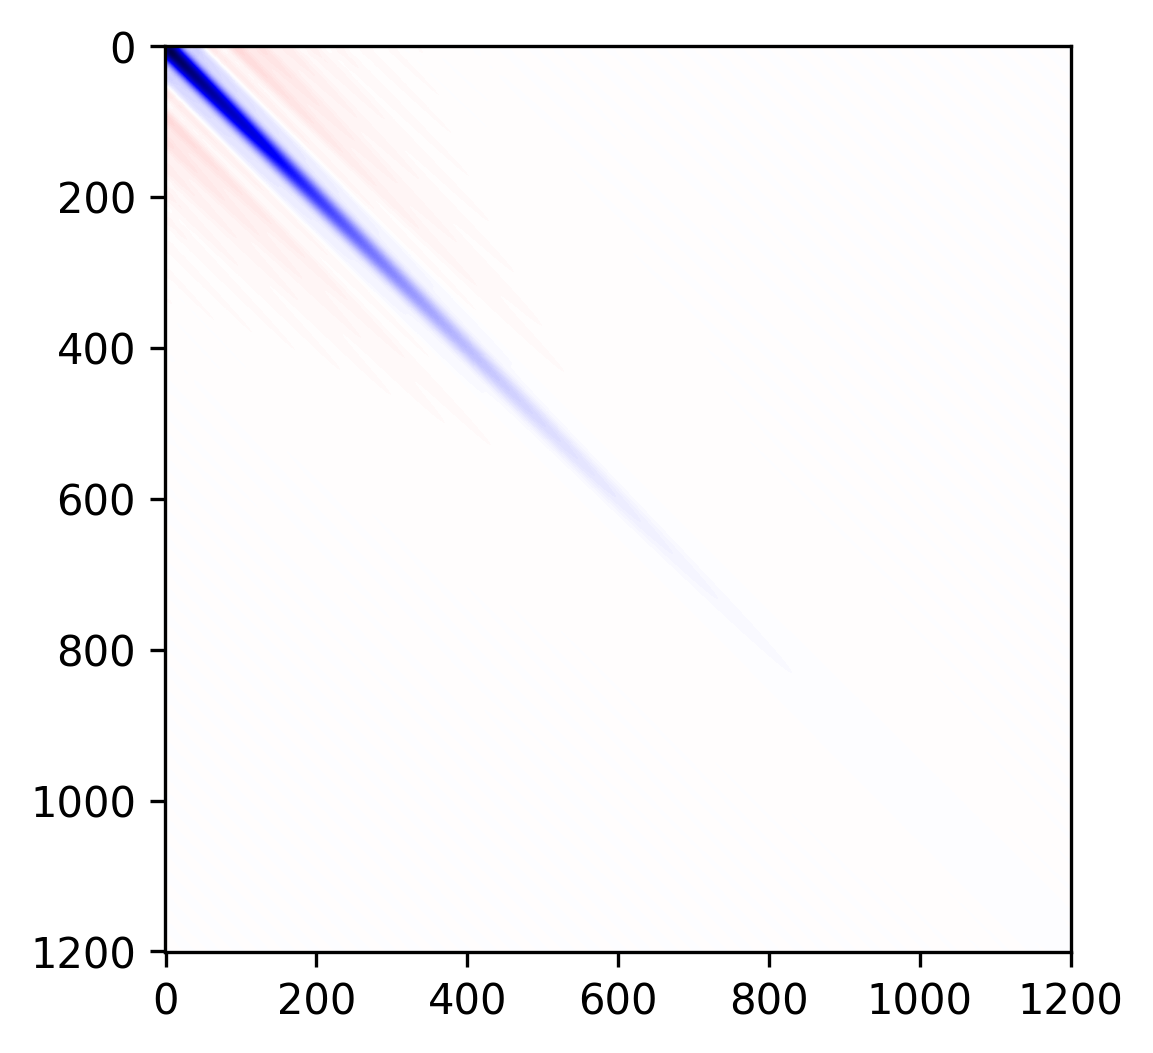

In [9]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300)
vb = np.max(np.abs(oup[0]))
plt.imshow(oup[0],
           vmin = -vb,
           vmax = vb,
           cmap = 'seismic')